This lab on Logistic Regression in R comes from p. 161-163 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. It was re-implemented in Fall 2016 in tidyverse format by Amelia McNamara and R. Jordan Crouser at Smith College.


# 4.6.3 Linear Discriminant Analysis

Now we will perform LDA on the `Smarket` data from the `ISLR` package. In `R`, we can fit a LDA model using the `lda()` function, which is part of the `MASS` library. Note: `dplyr` and `MASS` have a name clash around the word `select()`, so we need to do a little magic to make them play nicely.

In [1]:
list.of.packages <- c("dplyr","ISLR","MASS")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

In [2]:
library(MASS)
library(dplyr)
library(ISLR)
select <- dplyr::select


Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



The syntax for the `lda()` function is identical to that of `lm()`, and to that of
`glm()` except for the absence of the `family` option. As we did with logistic regression and KNN, we'll fit the model using only the observations before 2005, and then test the model on the data from 2005.

In [3]:
train = Smarket %>%
  filter(Year < 2005)

test = Smarket %>%
  filter(Year >= 2005)

model_LDA = lda(Direction~Lag1+Lag2, data = train)
print(model_LDA)

Call:
lda(Direction ~ Lag1 + Lag2, data = train)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

Coefficients of linear discriminants:
            LD1
Lag1 -0.6420190
Lag2 -0.5135293


The LDA output indicates prior probabilities of ${\hat{\pi}}_1 = 0.492$ and ${\hat{\pi}}_2 = 0.508$; in other words,
49.2% of the training observations correspond to days during which the
market went down.

The function also provides the group means; these are the average
of each predictor within each class, and are used by LDA as estimates
of $\mu_k$. These suggest that there is a tendency for the previous 2 days’
returns to be negative on days when the market increases, and a tendency
for the previous days’ returns to be positive on days when the market
declines. 

The coefficients of linear discriminants output provides the linear
combination of `Lag1` and `Lag2` that are used to form the LDA decision rule.

If $−0.642\times{\tt Lag1}−0.514\times{\tt Lag2}$ is large, then the LDA classifier will
predict a market increase, and if it is small, then the LDA classifier will
predict a market decline. 

We can use the `plot()` function to produce plots of the linear
discriminants, obtained by computing $−0.642\times{\tt Lag1}−0.514\times{\tt Lag2}$ for
each of the training observations.

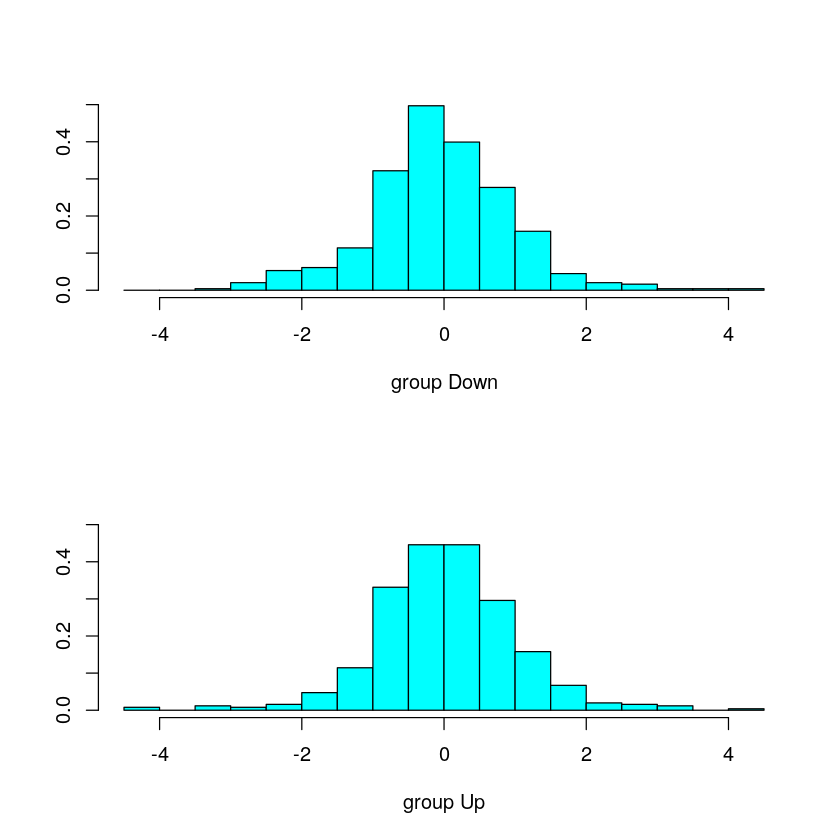

In [4]:
plot(model_LDA)

The `predict()` function returns a list with three elements. The first element,
`class`, contains LDA’s predictions about the movement of the market.
The second element, `posterior`, is a matrix whose $k^{th}$ column contains the
posterior probability that the corresponding observation belongs to the $k^{th}$
class. Finally, `x` contains the linear discriminants,
described earlier.

In [5]:
predictions_LDA = data.frame(predict(model_LDA, test))
names(predictions_LDA)

[1] "class"          "posterior.Down" "posterior.Up"   "LD1"

Let's check out the confusion matrix to see how this model is doing. We'll want to compare the **predicted class** (which we can find in the `class` column of the `predictions_LDA` data frame) to the true class.

In [6]:
predictions_LDA_2 = cbind(test, predictions_LDA)

predictions_LDA_2 %>%
  count(class, Direction)

predictions_LDA_2 %>%
  summarize(score = mean(class == Direction))

class,Direction,n
Down,Down,35
Down,Up,35
Up,Down,76
Up,Up,106


score
0.5595238


The LDA predictions are identical to the ones from our logistic model:

In [7]:
# Logistic model, for comparison
model_logistic = glm(Direction~Lag1+Lag2, data=train ,family=binomial)

logistic_probs = data.frame(probs = predict(model_logistic, test, type="response"))

predictions_logistic = logistic_probs %>%
  mutate(class = ifelse(probs>.5, "Up", "Down"))

predictions_logistic = cbind(test, predictions_logistic)

predictions_logistic %>%
  count(class, Direction)

predictions_logistic %>%
  summarize(score = mean(class == Direction))

class,Direction,n
Down,Down,35
Down,Up,35
Up,Down,76
Up,Up,106


score
0.5595238


# 4.6.4 Quadratic Discriminant Analysis
We will now fit a QDA model to the `Smarket` data. QDA is implemented
in `R` using the `qda()` function, which is also part of the `MASS` library. The
syntax is identical to that of `lda()`.

In [8]:
model_QDA = qda(Direction~Lag1+Lag2, data = train)
model_QDA

Call:
qda(Direction ~ Lag1 + Lag2, data = train)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

The output contains the group means. But it does not contain the coefficients
of the linear discriminants, because the QDA classifier involves a
_quadratic_, rather than a linear, function of the predictors. The `predict()`
function works in exactly the same fashion as for LDA.

In [9]:
predictions_QDA = data.frame(predict(model_QDA, test))

predictions_QDA = cbind(test, predictions_QDA)

predictions_QDA %>%
  count(class, Direction)

predictions_QDA %>%
  summarize(score = mean(class == Direction))

class,Direction,n
Down,Down,30
Down,Up,20
Up,Down,81
Up,Up,121


score
0.5992063


Interestingly, the QDA predictions are accurate almost 60% of the time,
even though the 2005 data was not used to fit the model. This level of accuracy
is quite impressive for stock market data, which is known to be quite
hard to model accurately. 

This suggests that the quadratic form assumed
by QDA may capture the true relationship more accurately than the linear
forms assumed by LDA and logistic regression. However, we recommend
evaluating this method’s performance on a larger test set before betting
that this approach will consistently beat the market!

# An Application to Carseats Data
Let's see how the `LDA/QDA` approach performs on the `Carseats` data set, which is
part of the `ISLR` library. 

Recall: this is a simulated data set containing sales of child car seats at 400 different stores.

In [10]:
summary(Carseats)

     Sales          CompPrice       Income        Advertising    
 Min.   : 0.000   Min.   : 77   Min.   : 21.00   Min.   : 0.000  
 1st Qu.: 5.390   1st Qu.:115   1st Qu.: 42.75   1st Qu.: 0.000  
 Median : 7.490   Median :125   Median : 69.00   Median : 5.000  
 Mean   : 7.496   Mean   :125   Mean   : 68.66   Mean   : 6.635  
 3rd Qu.: 9.320   3rd Qu.:135   3rd Qu.: 91.00   3rd Qu.:12.000  
 Max.   :16.270   Max.   :175   Max.   :120.00   Max.   :29.000  
   Population        Price        ShelveLoc        Age          Education   
 Min.   : 10.0   Min.   : 24.0   Bad   : 96   Min.   :25.00   Min.   :10.0  
 1st Qu.:139.0   1st Qu.:100.0   Good  : 85   1st Qu.:39.75   1st Qu.:12.0  
 Median :272.0   Median :117.0   Medium:219   Median :54.50   Median :14.0  
 Mean   :264.8   Mean   :115.8                Mean   :53.32   Mean   :13.9  
 3rd Qu.:398.5   3rd Qu.:131.0                3rd Qu.:66.00   3rd Qu.:16.0  
 Max.   :509.0   Max.   :191.0                Max.   :80.00   Max.   :18.0  

See if you can build a model that predicts `ShelveLoc`, the shelf location (Bad, Good, or Medium) of the product at each store. Don't forget to hold out some of the data for testing!

In [11]:
# Your code here

To get credit for this lab, please post your answers to the prompt in [#lab5](https://sds293.slack.com/messages/C7CR96LJ3).